# Pitch Control

In [1]:
DATADIR = "/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns

In [3]:
import sys  
sys.path.insert(0, '/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data')

In [6]:
import Metrica_IO_CF as mio
import Metrica_Viz_CF as mviz
import Metrica_Velocities_CF as mvel
import matplotlib.animation as manimation
import Metrica_PitchControl_CF as mpc

# Upload Cleaned Datasets
- `tracking_home.csv`
- `tracking_away.csv`
- `good_events_wrong_label.csv`
- `good_events.csv`
- `bad_events.csv`

In [8]:
game_id='/game_1'

In [9]:
good_events=pd.read_csv(DATADIR+game_id+'/good_events.csv')

In [10]:
good_events=good_events.rename(columns={'Unnamed: 0':'event_num'}).set_index('event_num')

In [11]:
good_events_bad_label=pd.read_csv(DATADIR+game_id+'/good_events_wrong_label.csv')

In [12]:
good_events_bad_label=good_events_bad_label.rename(columns={'Unnamed: 0':'event_num'}).set_index('event_num')

In [13]:
good_events=good_events.drop('ball_speed_x',axis=1).rename(columns={'ball_speed_y':'ball_speed'})

In [14]:
good_events_bad_label=good_events_bad_label.drop('ball_speed_x',axis=1).rename(columns={'ball_speed_y':'ball_speed'})

In [15]:
events=pd.concat([good_events,good_events_bad_label])

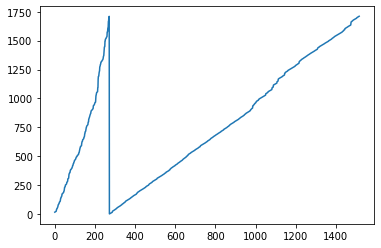

In [16]:
plt.plot(events.index)

### Events need to be reordered

In [17]:
events=events.reset_index().sort_values(by='event_num').set_index('event_num')

## Read in Tracking data

In [18]:
tracking_home=pd.read_csv(DATADIR+game_id+'/tracking_home.csv')
tracking_away=pd.read_csv(DATADIR+game_id+'/tracking_away.csv')

In [19]:
tracking_home=tracking_home.set_index('frameIdx')

In [20]:
tracking_away=tracking_away.set_index('frameIdx')

In [21]:
tracking_home['Team']='Home'
tracking_away['Team']='Away'

## Understanding how pitch control works

In [22]:
field_dimen=(100.6,68.9)
n_grid_cells_x=50
n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
dx = field_dimen[0]/n_grid_cells_x
dy = field_dimen[1]/n_grid_cells_y
xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.

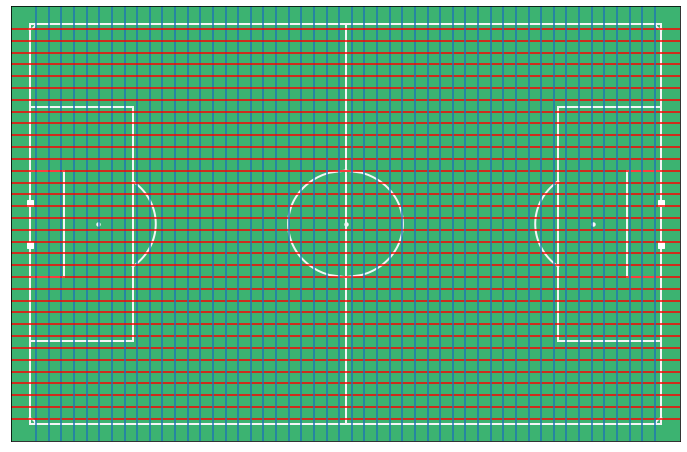

In [23]:
#plt.figure(figsize=(10,8))
mviz.plot_pitch()
for i,xline in enumerate(xgrid):
    plt.axvline(x=xline)
    if i <34:
        plt.axhline(y=ygrid[i],color='r')

Most important params appear to be ball start position - it then calculates pitch control @ each grid as shown above based on the ball position

**Ball start position is defined using EVENT DATA:**
- change pitch control model to pull ball start position from tracking data instead

**Improvements to make:**
- incorporate ball speed from target data into this model. Right now it is using a default of "average ball speed" that is a scalar and set as 15.0 m/s
- incorporate player specific max speeds. Currently within the `simple_time_to_intercept` function,  the `player` class and assumes certain player attributes like `vmax`,within `params` as `max_player_speed`==5m/s
   - starting point - choose max speed they used within a match
   - look into max_player_speed
   - between 6 and 10 is where it likely will be

## Start some computations

In [24]:
# first get pitch control model parameters
params = mpc.default_model_params()

In [25]:
print(params)

{'max_player_accel': 7.0, 'max_player_speed': 5.0, 'reaction_time': 0.7, 'tti_sigma': 0.45, 'kappa_def': 1.0, 'lambda_att': 4.3, 'lambda_def': 4.3, 'lambda_gk': 12.899999999999999, 'average_ball_speed': 15.0, 'int_dt': 0.04, 'max_int_time': 10, 'model_converge_tol': 0.01, 'time_to_control_att': 3.3202550055547313, 'time_to_control_def': 3.3202550055547313}


## Early Game Goalkeeper numbers

In [26]:
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home,int(events.iloc[100]['Start Frame'])),mio.find_goalkeeper(tracking_away,int(events.iloc[100]['Start Frame']))]

In [27]:
"home keeper number: {} away keeper number: {}".format(GK_numbers[0],GK_numbers[1])

'home keeper number: 18 away keeper number: 1'

## Need to recalculate goalkeepers with event late in the game because the goalie was subbed out

In [29]:
events.loc[1300]

Team                  Away
Type                    49
From                    11
To                     NaN
Start X             9.6672
                    ...   
away_9_vy         -4.07143
dist_btw               NaN
dist               7.25822
new_event_end_x        NaN
new_event_end_y        NaN
Name: 1300, Length: 211, dtype: object

In [30]:
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home,int(events.loc[1300]['Start Frame'])),
              mio.find_goalkeeper(tracking_away,int(events.loc[1300]['Start Frame']))]

In [31]:
events[events['Subtype']=='Goal']

,Team,Type,From,To,Start X,Start Y,End X,End Y,Start Frame,Start Time [s],...,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy,dist_btw,dist,new_event_end_x,new_event_end_y
event_num,,,,,,,,,,,,,,,,,,,,,
1271,Away,16,11.0,NaN,44.6101,-6.596,NaN,NaN,102161.0,4086.44,...,-1.250000,-1.500000,NaN,-3.464286,NaN,0.964286,NaN,1.076099,NaN,NaN
1314,Away,16,12.0,NaN,24.4701,-0.476,NaN,NaN,108011.0,4320.44,...,1.035714,-0.214286,NaN,0.607143,NaN,-1.607143,12.476702,16.446326,NaN,NaN


In [36]:
events.loc[1267:1271]

,Team,Type,From,To,Start X,Start Y,End X,End Y,Start Frame,Start Time [s],...,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy,dist_btw,dist,new_event_end_x,new_event_end_y
event_num,,,,,,,,,,,,,,,,,,,,,
1267,Away,1,1.0,12.0,17.9246,4.760,23.4631,29.580,101918.0,4076.72,...,0.642857,0.142857,NaN,1.071429,NaN,-0.892857,37.883755,4.876742,19.3185,32.150
1268,Away,1,12.0,14.0,23.4631,29.580,37.8632,27.948,101957.0,4078.28,...,0.428571,3.142857,NaN,1.142857,NaN,-0.857143,17.416696,4.348979,33.6001,27.088
1269,Away,1,14.0,1.0,37.7625,27.132,47.8325,14.960,102019.0,4080.76,...,0.107143,2.500000,NaN,-2.821429,NaN,0.071429,29.849263,3.009005,45.8900,17.258
1270,Away,1,1.0,11.0,47.8325,14.756,43.2003,-9.452,102095.0,4083.80,...,-1.071429,1.035714,NaN,-4.821429,NaN,-1.892857,73.352001,1.682130,44.7778,-8.868
1271,Away,16,11.0,NaN,44.6101,-6.596,NaN,NaN,102161.0,4086.44,...,-1.250000,-1.500000,NaN,-3.464286,NaN,0.964286,NaN,1.076099,NaN,NaN


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

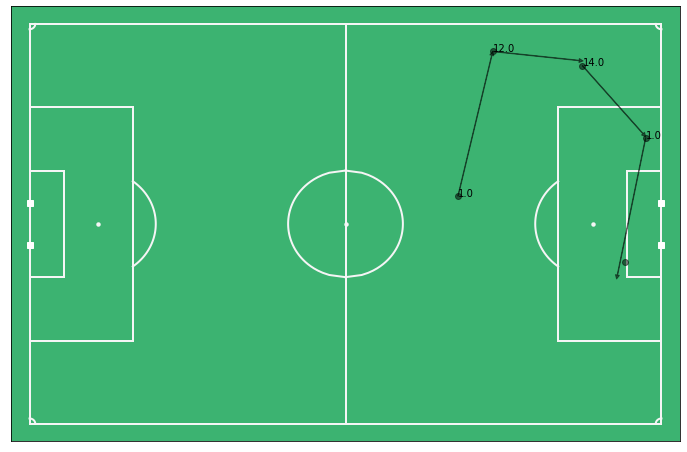

In [39]:
# plot the 3 events leading up to the first goal
mviz.plot_events(events.loc[1267:1271], color='k', indicators = ['Marker','Arrow'], annotate=True,)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

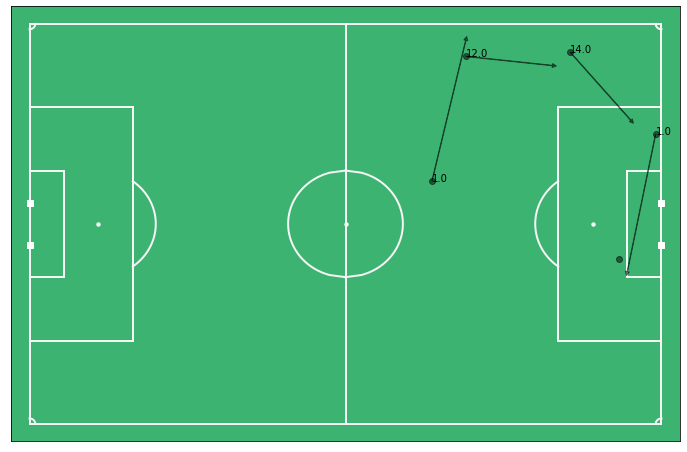

In [40]:
# plot the 3 events leading up to the first goal
mviz.plot_events(events.loc[1267:1271], color='k', indicators = ['Marker','Arrow'], annotate=True,adjust=True)

### Play with a cute little loop to calculate pitch control for the pass events leading up to the goal

In [41]:
def isNaN(num):
    '''cute lil guy that determines if an element is nan or not'''
    return num != num

----
CPU times: user 9.75 s, sys: 97.2 ms, total: 9.85 s
Wall time: 10.2 s


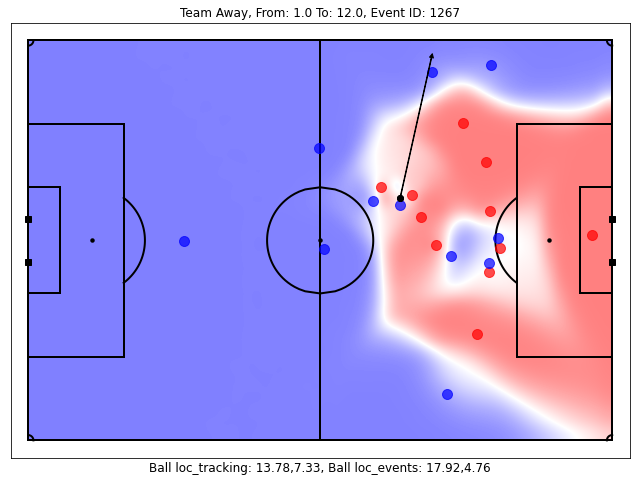

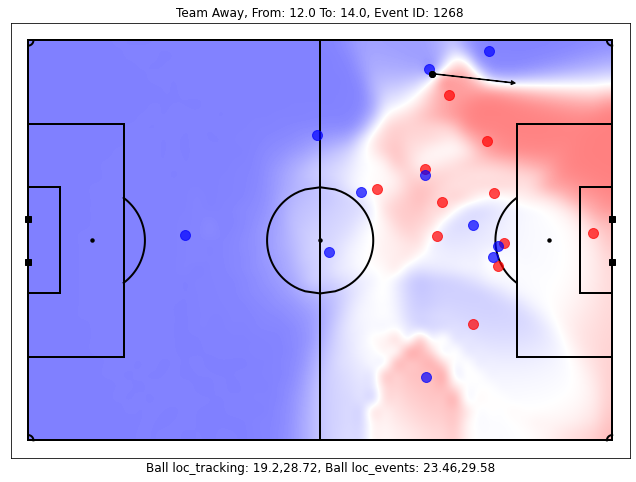

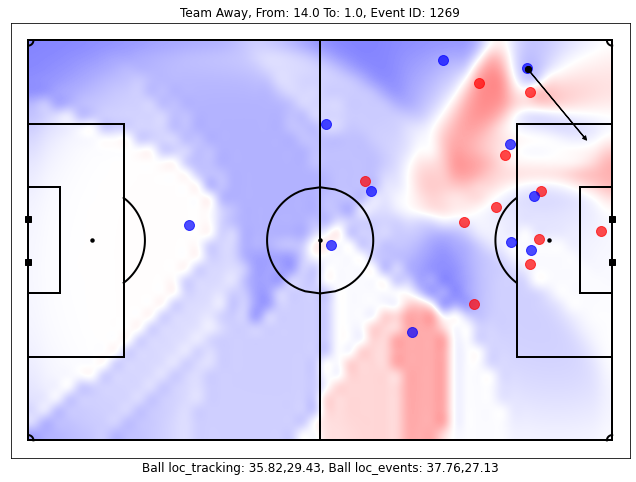

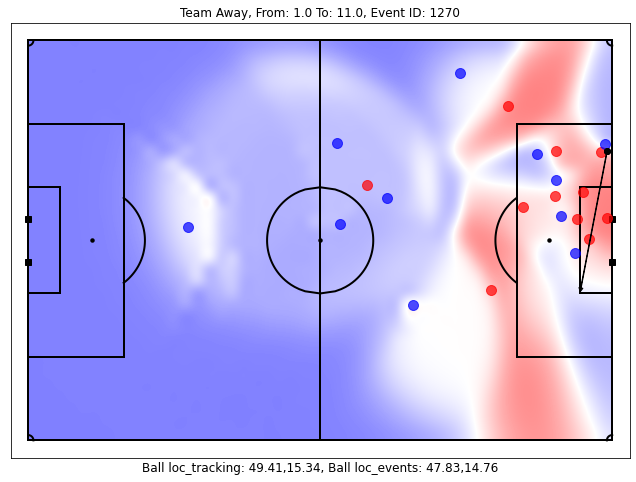

In [45]:
%%time
for i,row in events.loc[1267:1271].iterrows():
    if isNaN(row['End X']):
        print('----')
    else:
        # evaluated pitch control surface for each event
        event_frame=row['Start Frame']
        PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(i, events, tracking_home, tracking_away, params, GK_numbers, n_grid_cells_x = 50,offsides=True,field_dimen=(100.6,68.9))
        fig, ax=mviz.plot_pitchcontrol_for_event(i, events,  tracking_home, tracking_away, PPCF, annotate=False,field_dimen=(100.6,68.9),include_player_velocities=False)
        ax.set_title("Team {}, From: {} To: {}, Event ID: {}".format(row['Team'],row['From'], row['To'],i))
        ax.set_xlabel("Ball loc_tracking: {},{}, Ball loc_events: {},{}".format(tracking_home['ball_x'].loc[event_frame],
                                                                                tracking_home['ball_y'].loc[event_frame],
                                                                                round(row['Start X'],2), round(row['Start Y'],2)),fontsize=12)



# Visualizing Null values in tracking Data

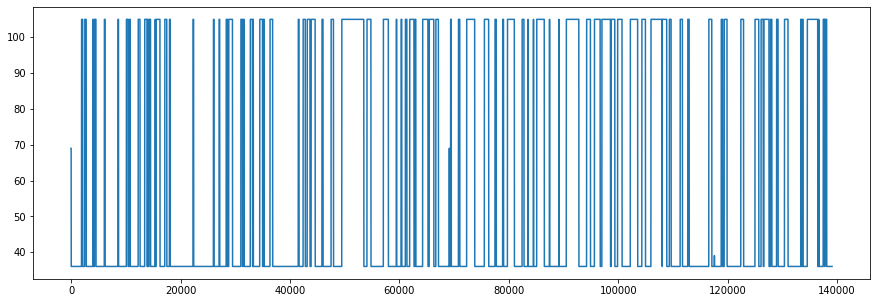

In [46]:
plt.figure(figsize=(15,5))
plt.plot(tracking_home.isnull().sum(axis=1))

In [47]:
# missing data
total = tracking_home.isnull().sum(axis=1).sort_values(ascending=False)
#percent = (events.isnull().sum()/events.isnull().count()).sort_values(ascending=False)

In [48]:
total.iloc[45377:45383]

frameIdx
2688     105
2689     105
2690     105
69466     69
47943     69
60421     69
dtype: int64

## So we've got roughly 45 k of empty frames

In [49]:
#Calculate % missing data
tracking_home.isna().sum(axis=1)/len(tracking_home.columns)

frameIdx
0         0.633028
1         0.633028
2         0.633028
3         0.633028
4         0.330275
            ...   
139057    0.330275
139058    0.330275
139059    0.330275
139060    0.330275
139061    0.330275
Length: 139062, dtype: float64

# Quantifying Pass probability

## Defining Home/Away Passes for analysis

In [50]:
# away passes
away_passes=events[(events['Subtype']=='Pass') & (events['Team']=="Away")]

In [51]:
away_passes.shape

(587, 211)

In [52]:
# home passes
home_passes=events[(events['Subtype']=='Pass') & (events['Team']=="Home")]

In [53]:
home_passes.shape

(381, 211)

## AWAY TEAM ASSESSMENT

In [70]:
away_pass_success_probability=[]

In [71]:
for i,row in away_passes.iterrows():
    ### This if statement checks if more than 90/107 rows are nan, if so, it skips
    if list(tracking_home[tracking_home.index==row['Start Frame']].isnull().sum(axis=1))[0]>90:
        away_pass_success_probability.append( (i,np.nan) )
    else:
        pass_start_pos = np.array([row['ball_x'],row['ball_y']])
        pass_target_pos = np.array([row['new_event_end_x'],row['new_event_end_y']])
        pass_frame = row['Start Frame']
        # find goalkeepers for offside calculation and so player initialization works properly 
        #      - calculating them for each frame in case of substitutions
        GK_numbers = [mio.find_goalkeeper(tracking_home,int(row['Start Frame'])),
                      mio.find_goalkeeper(tracking_away,int(row['Start Frame']))]
        attacking_players = mpc.initialise_players(tracking_away.loc[pass_frame],'away',params, GK_numbers[1])
        defending_players = mpc.initialise_players(tracking_home.loc[pass_frame],'home',params, GK_numbers[0])
        
        if row['ball_speed']==0:
            ballspeed=away_passes['ball_speed'].median()
        else:    
            ballspeed=row['ball_speed']
        
        Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params,ball_speed=ballspeed)

        away_pass_success_probability.append( (i,Patt) )

In [72]:
len(away_pass_success_probability)

587

Text(0, 0.5, 'Frequency')

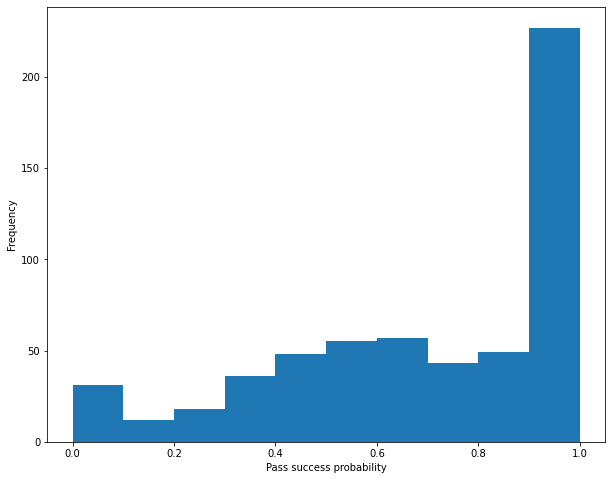

In [73]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist( [p[1] for p in away_pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  


## How this compares to pass probability - "Pass Difficulty"
****Plot regression

In [74]:
away_passes.shape

(587, 211)

In [75]:
second_tuple_elements=[]
for a_tuple in away_pass_success_probability:
#Sequentially access each tuple in `tuple_list`

    second_tuple_elements.append(a_tuple[1])

In [76]:
away_passes['Pass_success_proba']=second_tuple_elements

/opt/anaconda3/envs/bootcamp_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


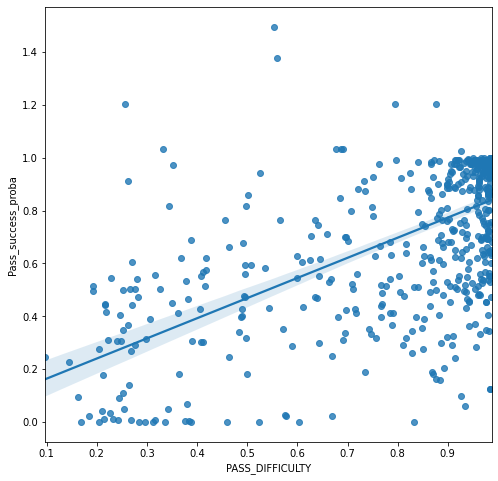

In [80]:
plt.figure(figsize=(8,8))
sns.regplot(x="PASS_DIFFICULTY", y="Pass_success_proba", data=away_pass_probas);

In [81]:
# sort the passes by pitch control probability
away_pass_success_probability = sorted(away_pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_away_passes = events.loc[ [p[0] for p in away_pass_success_probability if (p[1]<0.2)] ]


In [82]:
away_pass_success_probability[:20]

[(275, 2.438764266782041e-06),
 (455, 4.330529981233623e-05),
 (1238, 5.027428888129237e-05),
 (1002, 5.367346218181307e-05),
 (176, 5.6163293978488645e-05),
 (219, 7.26389622708169e-05),
 (676, 0.00014625100082840393),
 (866, 0.001119257083000941),
 (939, 0.007873620978919875),
 (938, 0.024918452268256626),
 (894, 0.05058442862668434),
 (954, 0.34679798174061305),
 (991, 0.3647082090255939),
 (891, 0.3903426165207353),
 (1013, 0.4233140308157254),
 (1000, 0.43226779131961673),
 (952, 0.44793952326899694),
 (888, 0.46811310441647924),
 (1004, 0.47297792379102077),
 (902, 0.51599998790601)]

In [85]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in away_pass_success_probability[:20]:
    if p[0]+1 in events.index:
        outcome = events.loc[ p[0]+1 ]['Subtype']
        print( p[1], outcome )
        #print('here')
    elif p[0]+2 in events.index:
        outcome = events.loc[ p[0]+2 ]['Subtype']
        print( p[1], outcome )
        #print('here')
    else:
        outcome = events.loc[ p[0]+3 ]['Subtype']
        print( p[1], outcome )
        #print('there')

Event following a risky (completed) pass
2.438764266782041e-06 Keeper_pick-up
4.330529981233623e-05 Interception
5.027428888129237e-05 Pass
5.367346218181307e-05 Formation_change
5.6163293978488645e-05 Keeper_pick-up
7.26389622708169e-05 Ball_recovery
0.00014625100082840393 Take_On
0.001119257083000941 Pass
0.007873620978919875 Pass
0.024918452268256626 Pass
0.05058442862668434 Pass
0.34679798174061305 Foul
0.3647082090255939 Pass
0.3903426165207353 Foul
0.4233140308157254 Pass
0.43226779131961673 Pass
0.44793952326899694 Pass
0.46811310441647924 Ball_touch
0.47297792379102077 Offside_Pass
0.51599998790601 Pass


## Pitch control at these risky passes would be interesting

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

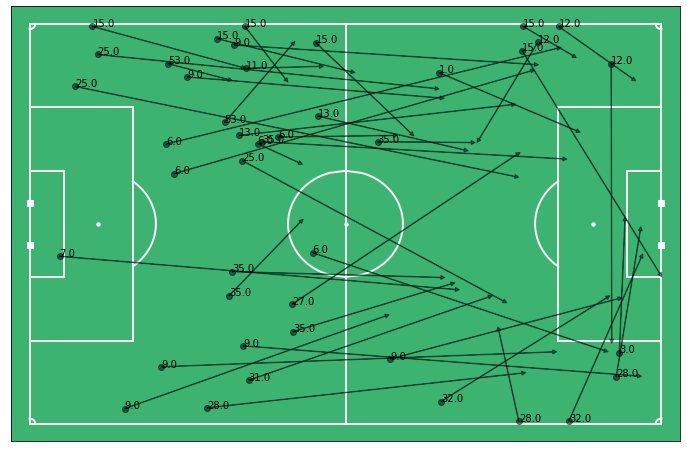

In [84]:
# plot the events
mviz.plot_events( risky_away_passes, color='k', indicators = ['Marker','Arrow'], annotate=True,field_dimen=(100.6,68.9) )


## Quantifying Pass Probability for HOME TEAM

In [ ]:
home_pass_success_probability=[]

In [ ]:
for i,row in home_passes.iterrows():
    ### This if statement checks if more than 90/107 rows are nan, if so, it skips
    if list(tracking_home[tracking_home.index==row['Start Frame']].isnull().sum(axis=1))[0]>90:
        pass
    else:
        pass_start_pos = np.array([row['Start X'],row['Start Y']])
        pass_target_pos = np.array([row['End X'],row['End Y']])
        pass_frame = row['Start Frame']
        # find goalkeepers for offside calculation and so player initialization works properly 
        #      - calculating them for each frame in case of substitutions
        GK_numbers = [mio.find_goalkeeper(tracking_home,int(row['Start Frame'])),
                      mio.find_goalkeeper(tracking_away,int(row['Start Frame']))]
        attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'home',params, GK_numbers[0])
        defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'away',params, GK_numbers[1])

        Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

        home_pass_success_probability.append( (i,Patt) )

In [ ]:
len(home_pass_success_probability)

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist( [p[1] for p in home_pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  


## How this compares to pass probability - "Pass Difficulty"
****Plot regression

In [ ]:
# sort the passes by pitch control probability
home_pass_success_probability = sorted(home_pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
wrong_home_passes = events.loc[ [p[0] for p in home_pass_success_probability if (p[1]<0.2)] ]


In [ ]:
home_pass_success_probability[:20]

In [ ]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in home_pass_success_probability[:20]:
    if p[0]+1 in events.index:
        outcome = events.loc[ p[0]+1 ]['Subtype']
        print( p[1], outcome )
        #print('here')
    else:
        outcome = events.loc[ p[0]+2 ]['Subtype']
        print( p[1], outcome )
        #print('there')

## Pitch control at these risky passes would be interesting

In [ ]:
# plot the events
mviz.plot_events( wrong_home_passes, color='k', indicators = ['Marker','Arrow'], annotate=True,field_dimen=(100.6,68.9) )


# Plot Pitch surface for 5-10 riskiest passes for HOME TEAM

In [ ]:
%%time
for i,row in wrong_home_passes.iloc[:6].iterrows():
    if isNaN(row['End X']):
        print('----')
    else:
        # evaluated pitch control surface for each event
        PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(i, events, tracking_home, tracking_away, params, GK_numbers, n_grid_cells_x = 50,offsides=True,field_dimen=(100.6,68.9))
        fig, ax=mviz.plot_pitchcontrol_for_event(i, events,  tracking_home, tracking_away, PPCF, annotate=True,field_dimen=(100.6,68.9))
        ax.set_title("Team {}, From: {} To: {}, Event ID: {}".format(row['Team'],row['From'], row['To'],i))
        ax.set_xlabel("Ball loc_tracking: {},{}, Ball loc_events: {},{}".format(tracking_home['ball_x'].loc[event_frame],
                                                                                tracking_home['ball_y'].loc[event_frame],
                                                                                round(row['Start X'],2), round(row['Start Y'],2)),fontsize=12)



## Event data is not matching up at all in thest ones

In [ ]:
%%time
for i,row in wrong_home_passes.iloc[7:15].iterrows():
    if isNaN(row['End X']):
        print('----')
    else:
        # evaluated pitch control surface for each event
        PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(i, events, tracking_home, tracking_away, params, GK_numbers, n_grid_cells_x = 50,offsides=True,field_dimen=(100.6,68.9))
        fig, ax=mviz.plot_pitchcontrol_for_event(i, events,  tracking_home, tracking_away, PPCF, annotate=True,field_dimen=(100.6,68.9))
        ax.set_title("Team {}, From: {} To: {}, Event ID: {}".format(row['Team'],row['From'], row['To'],i))
        ax.set_xlabel("Ball loc_tracking: {},{}, Ball loc_events: {},{}".format(tracking_home['ball_x'].loc[event_frame],
                                                                                tracking_home['ball_y'].loc[event_frame],
                                                                                round(row['Start X'],2), round(row['Start Y'],2)),fontsize=12)



# Look at risky passes that are between 20 and 40% probability (likely more realistic these are real

In [ ]:
# sort the passes by pitch control probability
home_pass_success_probability = sorted(home_pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_home_passes = events.loc[ [p[0] for p in home_pass_success_probability if (p[1]<0.2) and (p[1]<0.4) ]]


In [ ]:
risky_home_passes

In [ ]:
%%time
for i,row in risky_home_passes.iloc[:6].iterrows():
    if isNaN(row['End X']):
        print('----')
    else:
        # evaluated pitch control surface for each event
        PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(i, events, tracking_home, tracking_away, params, GK_numbers, n_grid_cells_x = 50,offsides=True,field_dimen=(100.6,68.9))
        fig, ax=mviz.plot_pitchcontrol_for_event(i, events,  tracking_home, tracking_away, PPCF, annotate=True,field_dimen=(100.6,68.9))
        ax.set_title("Team {}, From: {} To: {}, Event ID: {}".format(row['Team'],row['From'], row['To'],i))
        ax.set_xlabel("Ball loc_tracking: {},{}, Ball loc_events: {},{}".format(tracking_home['ball_x'].loc[event_frame],
                                                                                tracking_home['ball_y'].loc[event_frame],
                                                                                round(row['Start X'],2), round(row['Start Y'],2)),fontsize=12)



# Hmmm - COME BACK TO THIS TOMORROW